## SVAE

In [1]:
from __future__ import print_function, division

import sys
import numpy
import numpy as np
import downhill
import theano
import theano.tensor as T

from mlp import HiddenLayer
from dA import dA
#from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

from ProcessingData import load_data, normalize_data
from Methods import auc_density, auc_AEbased
from Plot_Curves import Plotting_End2End_RE, Plotting_Pre_RE, Plotting_AUC_RE, Plotting_Pre_RE1
from Plot_Curves import Plotting_AUC_Batch_Size, Plotting_Monitor, plot_auc_size_input, visualize_hidden
from Plot_Curves import visualize_hidden1, histogram_z, Plotting_Loss_Component, plot_auc_size_2
from nnet_architecture import hyper_parameters
from stopping_para import stopping_para_vae


path = "./Results/Exp_Hidden/"

"Check whether weights matrix is updated or not"
def check_weight_update(sda):
    np.set_printoptions(precision=4, suppress=True)
    "Check whether weights matrix is updated or not"
    for i in range(sda.n_layers):
        print("\n %d" %i)
        print (sda.Autoencoder_layers[i].W.get_value(borrow=True))

    for j in range(sda.n_layers, 2*sda.n_layers):
        print("\n %d" % j)
        print (sda.Autoencoder_layers[j].W.eval())

    print ("\n ************************************ ")



class SdA(object):

    def __init__(self, numpy_rng, theano_rng=None, n_ins=100, hidden_layers_sizes=[50, 30]):

        self.encoder = []
        self.decoder = []
        self.params  = []
        self.n_layers = len(hidden_layers_sizes)

        self.rng = theano.tensor.shared_randomstreams.RandomStreams(numpy_rng.randint(2 ** 30))

        assert self.n_layers > 0

        self.x = T.matrix('x')

        for i in range(self.n_layers):
            # the size of the input is either the number of hidden units of
            # the layer below or the input size if we are on the first layer
            if (i == 0):
                input_size  = n_ins
                layer_input = self.x
            else:
                input_size  = hidden_layers_sizes[i - 1]
                layer_input = self.encoder[-1].output

            "Not the middle hidden layer"
            if (i < self.n_layers-1):
                encoder_layer = HiddenLayer(rng = numpy_rng,
                                    input       = layer_input,
                                    n_in        = input_size,
                                    n_out       = hidden_layers_sizes[i],
                                    activation  = T.tanh)
                self.encoder.append(encoder_layer)
                self.params.extend(encoder_layer.params)

            else:
                "The middle hidden layer, linear"
                encoder_mu = HiddenLayer(rng = numpy_rng,
                                    input    = self.encoder[i-1].output,
                                    n_in     = input_size,
                                    n_out    = hidden_layers_sizes[i])

                encoder_var = HiddenLayer(rng= numpy_rng,
                                    input    = self.encoder[i-1].output,
                                    n_in     = input_size,
                                    n_out    = hidden_layers_sizes[i])

                self.encoder.append(encoder_mu)
                self.params.extend(encoder_mu.params)

                self.encoder.append(encoder_var)
                self.params.extend(encoder_var.params)


        "*************** Sample z **************"
        mu       = self.encoder[-2].output
        log_var  = self.encoder[-1].output
        sample_z = self.sample_z(mu, log_var)

        "*************** Decoder ***************"
        i = self.n_layers-1
        while (i >=0):
            input_size = hidden_layers_sizes[i]
            if ( i > 0):
                output_size = hidden_layers_sizes[i-1]
            else:
                output_size =  n_ins

            if (i==self.n_layers-1): 
                layer_input = sample_z
                decoder_layer = HiddenLayer(rng = numpy_rng,
                                        input   = layer_input,
                                        n_in    = input_size,
                                        n_out   = output_size,
                                        activation = T.tanh)  
                self.decoder.append(decoder_layer)
                self.params.extend(decoder_layer.params)
            else:
                layer_input = self.decoder[-1].output
                decoder_layer = HiddenLayer(rng = numpy_rng,
                                        input   = layer_input,
                                        n_in    = input_size,
                                        n_out   = output_size,
                                        activation = T.tanh,
                                        W = self.encoder[i].W.T)

                self.decoder.append(decoder_layer)
                self.params.append(decoder_layer.b)
            i = i - 1

        "******************* End To End Cost function ************************"
        z_mu  = self.encoder[-2].output
        z_var = self.encoder[-1].output
        z     = self.decoder[-1].output


        self.recon = (((self.x - z)**2).mean(1)).mean()
        
        self.KL    = T.mean((0.5)*T.mean(T.exp(z_var) + z_mu**2 - 1 - z_var, 1))
        
        self.end2end_cost = self.recon + self.KL        

    "**************************** Sample z ***********************************"
    def sample_z(self, mu, log_var):
        eps = self.rng.normal(mu.shape, 0.0, 1.0 , dtype = theano.config.floatX)
        sample_z = mu + T.exp(log_var / 2) * eps
        return sample_z
    
    
    def Recon_KL_loss_batch(self, train_x, batch_size):

        index = T.lscalar('index')
        
        batch_begin = index * batch_size
       
        batch_end = batch_begin + batch_size
        KL1 = self.lamda*T.log10(self.KL+1)
        loss_com = theano.function([index],
                             outputs = [self.recon, KL1],
                             givens={self.x: train_x[batch_begin : batch_end]})
        return loss_com

    def Recon_KL_Loss(self, train_x, batch_size):
        n_train = train_x.get_value().shape[0]
        n_batches = (int)(n_train/batch_size)
        loss_com = self.Recon_KL_loss_batch(train_x, batch_size)
        loss = np.empty([0,2])
        for batch_index in range(n_batches):
          l = loss_com(index = batch_index)
          loss = np.append(loss, [l[0], l[1]])
        loss = np.reshape(loss, (-1,2))

        return (loss.mean(0))

    "************************** Get Mu and Log_var ****************************"
    def get_mu_logvar(self,data_set):
        data_size = data_set.get_value().shape[0]
        index   = T.lscalar('index')
        mu      =  self.encoder[-2].output
        log_var =  self.encoder[-1].output
        mu_logvar = theano.function([index],
                                    outputs = [mu, log_var],
                                    givens={self.x: data_set[index : data_size]})
        return mu_logvar(0)


    "****** Error on train_x and valid_x before optimization process **********"
    def Loss_train_valid(self, train_x, valid_x):
        index = T.lscalar('index')

        train_size = train_x.get_value().shape[0]
        tm = theano.function([index],
                             outputs = self.end2end_cost,
                             givens={self.x: train_x[index : train_size]})

        valid_size = valid_x.get_value().shape[0]
        vm = theano.function([index],
                             outputs = self.end2end_cost,
                             givens={self.x: valid_x[index : valid_size]})

        return tm(0), vm(0)

    "**************************** Get hidden data z **************************"
    def get_hidden_data(self,data_set):
        data_size = data_set.get_value().shape[0]
        index = T.lscalar('index')
        mu      =  self.encoder[-2].output
        log_var =  self.encoder[-1].output
        z = self.sample_z(mu, log_var)
        hidden_data = theano.function([index],
                                      outputs = z,
                                      givens={self.x: data_set[index : data_size]})
        return hidden_data(0)


    "************get data from the output of Autoencoder**********************"
    def get_output_data(self,data_set):
        data_size = data_set.get_value().shape[0]
        index  = T.lscalar('index')
        y_data = theano.function([index],
                                      outputs = self.decoder[-1].output,
                                      givens={self.x: data_set[index : data_size]})
        return y_data(0)

    "******************** Histogram z, z_mu and z_var ************************"
    def Plot_histogram_z(self, train_set, test_set, actual, epoch, path):
        z_train    = self.get_hidden_data(train_set)
        mu, logvar = self.get_mu_logvar(train_set)

        np.savetxt(path + "Visualize_histogram/" + "z_train_" + str(epoch) + "_" + str(self.alpha)+".csv", z_train, delimiter=",", fmt='%f' )

        histogram_z(z_train[:,0],        'z'  , self.alpha, epoch, path)

    "********************* Compute AUC on hidden data *************************"
    def Compute_AUC_Hidden(self, train_set, test_set, actual, norm, data_name):
        z_train = self.get_hidden_data(train_set)           #get hidden values
        z_test  = self.get_hidden_data(test_set)            #get hidden values
        y_test  = self.get_output_data(test_set)            #get prediction values
        "Compute performance of classifiers on latent data"
        lof, cen, dis, kde, svm05, svm01 = auc_density(z_train, z_test, actual, norm)
        ae                               = auc_AEbased(test_set.get_value(), y_test, actual)
        return lof, cen, dis, kde, svm05, svm01, ae

    "**************************************************************************"
    def Save_Hidden_Data(self, train_set, test_set, data_name, path):
        z_train = self.get_hidden_data(train_set)      #get hidden values
        z_test  = self.get_hidden_data(test_set)       #get hidden values
        np.savetxt(path + data_name + "_train_z.csv", z_train, delimiter=",", fmt='%f' )
        np.savetxt(path + data_name + "_test_z.csv" ,  z_test, delimiter=",", fmt='%f' )

    "******** Training End-to-End Early-stopping by Downhill Package *********"
    def End2end_Early_stopping(self, numpy_rng, dataset, n_validate, data_name,
                               batch_size, end2end_lr, algo, norm, patience, validation):

        train_X, test_X, actual = dataset
        valid_x = train_X.get_value()[:n_validate]
        train_x = train_X.get_value()[n_validate:]
        "for compute tm and vm before optimization process"

        "Training network by downhill"
        #'adadelta' 'adagrad (default 0.01)' 'adam''esgd' 'nag''rmsprop' 'rprop' 'sgd'
        opt = downhill.build(algo = algo, params= self.params, loss = self.end2end_cost, inputs = [self.x])
        train = downhill.Dataset(train_x, batch_size = batch_size, rng = numpy_rng)
        valid = downhill.Dataset(valid_x, batch_size = len(valid_x), rng = numpy_rng)

        "***** Monitor before optimization *****"
        stop_ep = 0
        RE = np.empty([0,3])

        for tm, vm in opt.iterate(train,                     # 5, 5, 1e-2, 0.9
                                  valid,
                                  patience = patience,               # 10
                                  validate_every = validation,            # 5
                                  min_improvement = 1e-3,       # 1e-3
                                  #learning_rate =  end2end_lr,  # 1e-4
                                  momentum = 0.0,
                                  nesterov = False):
            stop_ep = stop_ep+1

            re = np.column_stack([stop_ep, vm['loss'], tm['loss']])
            RE = np.append(RE, re)

            if (stop_ep >= 1000):
                break

        RE = np.reshape(RE, (-1,3))
        Plotting_End2End_RE(RE, stop_ep, 0.0, 0.4, data_name, path)
        np.savetxt(path +  data_name + "_training_error1.csv", RE, delimiter=",", fmt='%f' )

        np.set_printoptions(precision=6, suppress=True)
        print ("\n ",RE[stop_ep-1])

        return RE[stop_ep-1]



def test_SdA(pre_lr=0.01, end2end_lr=1e-4, algo = 'sgd',
             dataset=[], data_name = "WBC", n_validate = 0, norm = "maxabs",
             batch_size=10, hidden_sizes = [1,1,1],
             patience = 1, validation = 1):

    numpy_rng = numpy.random.RandomState(89677)    
    train_X, test_X, actual = dataset               

    input_size = train_X.get_value().shape[1]      
    train_x    = train_X.get_value()[n_validate:]   
    n_train_batches   = train_x.shape[0]
    n_train_batches //= batch_size                 

    
    sda = SdA(numpy_rng = numpy_rng, n_ins = input_size,
              hidden_layers_sizes = hidden_sizes)


    RE = sda.End2end_Early_stopping(numpy_rng, dataset, n_validate, data_name,
                               batch_size, end2end_lr, algo, norm, patience, validation)
    return sda, RE


def Main_Test():

    list_data =  ["PageBlocks", "WPBC", "PenDigits", "GLASS", "Shuttle", "Arrhythmia",\
                 "CTU13_10", "CTU13_08","CTU13_09","CTU13_13",\
                 "Spambase", "UNSW", "NSLKDD", "InternetAds"]
    
    norm         = "maxabs"           

    print ("+ Data: ", list_data)
    print ("+ Scaler: ", norm)

    AUC_Hidden = np.empty([0,10])     
    num = 0                          
    for data in list_data:
        num = num + 1

        h_sizes = hyper_parameters(data)                  
        train_set, test_set, actual = load_data(data)     

        train_X, test_X = normalize_data(train_set, test_set, norm)  #Normalize data

        train_X = theano.shared(numpy.asarray(train_X, dtype=theano.config.floatX), borrow=True)
        test_X  = theano.shared(numpy.asarray(test_X,  dtype=theano.config.floatX), borrow=True)

        datasets = [(train_X), (test_X), (actual)]          

        in_dim   = train_set.shape[1]                       
        n_vali   = (int)(train_set.shape[0]/5)              
        n_train  = len(train_set) - n_vali                 
        #batch    = int(n_train/20)                         
                                                    
        pat, val, batch, n_batch = stopping_para_vae(n_train)

        print ("\n" + str(num) + ".", data, "..." )
        print (" + Hidden Sizes: ",in_dim, h_sizes, "- Batch_sizes:", batch)
        print (" + Data: %d (%d train, %d vali) - %d normal, %d anomaly"\
            %(len(train_set), n_train, n_vali, \
            len(test_set[(actual == 1)]), len(test_set[(actual == 0)])))

        print(" + Patience: %5.0d, Validate: %5.0d,  \n + Batch size: %5.0d, n batch:%5.0d"\
             %(pat, val, batch, n_batch))

                               
        sda, re = test_SdA(pre_lr       = 1e-2,            
                                   end2end_lr   = 1e-4,
                                   algo         = 'adadelta',
                                   dataset      = datasets,
                                   data_name    = data,
                                   n_validate   = n_vali,
                                   norm         = norm,
                                   batch_size   = batch,
                                   hidden_sizes = h_sizes,
                                   patience     = pat,
                                   validation   = val)

        #Computer AUC on hidden data
        lof,cen,dis,kde,svm05,svm01,ae  = sda.Compute_AUC_Hidden(train_X, test_X, actual, norm, data)
        auc_hidden = np.column_stack([batch, re[0], lof, cen, dis, kde, svm05, svm01, ae , 100*re[2]])
        AUC_Hidden = np.append(AUC_Hidden, auc_hidden)

        sda.Save_Hidden_Data(train_X, test_X, data, path)

        AUC_Hidden  =  np.reshape(AUC_Hidden, (-1, 10))
        np.set_printoptions(precision=3, suppress=True)
        column_list = [2,3,4,5,6,7,8,9]
        print("    LOF    CEN    MDIS   KDE   SVM5    SVM1    AE    RE*100")
        print (AUC_Hidden[:,column_list])
        print("\n")
        
    AUC_Hidden  =  np.reshape(AUC_Hidden, (-1, 10))
    np.set_printoptions(precision=3, suppress=True)
    column_list = [2,3,4,5,6,7,8,9]
    print("    LOF    CEN    MDIS   KDE   SVM5    SVM1    AE    RE*100")
    print (AUC_Hidden[:,column_list])

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


VAE
+ Scaler:  maxabs
+ Corruptions:  [0.1, 0.1, 0.1]

1. maiwilab ...
 + Hidden Sizes:  63 [85, 49, 12] - Batch_sizes: 100
 + Data: 68776 (55021 train, 13755 vali) - test: 17195 normal, 2806 anomaly
 + Patience:     4, Validate:     1,  
 + Batch size:   100, n batch:  550
dataset0: 551 of 551 mini-batches from (55021, 63)
dataset1: 1 of 1 mini-batches from (13755, 63)
downhill: compiling evaluation function
downhill: compiling ADADELTA optimizer
downhill: setting: rms_halflife = 14
downhill: setting: rms_regularizer = 1e-08
downhill: setting: patience = 4
downhill: setting: validate_every = 1
downhill: setting: min_improvement = 0.001
downhill: setting: max_gradient_norm = 0
downhill: setting: max_gradient_elem = 0
downhill: setting: learning_rate = TensorConstant{0.0001}
downhill: setting: momentum = 0.0
downhill: setting: nesterov = False
downhill: validation 0 loss=0.387713 *
downhill: ADADELTA 1 loss=0.099645
downhill: validation 1 loss=0.066837 *
downhill: ADADELTA 2 loss=0.0658

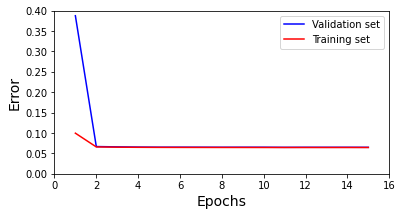


  [15.        0.064964  0.06451 ]
cen
AUC 0.4980982678043995
Precision 0.8614084507042253
Recall 0.533527188136086
f1_score 0.6589333812174537
TPR 0.533527188136086
FPR 0.5260156806842481
KDE AE/DensityBasedOneClassClassifier
AUC 0.49755962641429885
Precision 0.8615602836879432
Recall 0.5298633323640594
f1_score 0.6561757292041772
TPR 0.5298633323640594
FPR 0.5217391304347826
SVM05
AUC 0.4975606419758102
Precision 0.8608999879358186
Recall 0.8300087234661239
f1_score 0.8451721789595238
TPR 0.8300087234661239
FPR 0.8218104062722738
SVM01
AUC 0.4974881847708468
Precision 0.8614669323465225
Recall 0.528002326257633
f1_score 0.6547198384654215
TPR 0.528002326257633
FPR 0.5203136136849608


In [ ]:
import pandas as pd
import numpy
norm         = "maxabs"                
corruptions  = [0.1, 0.1, 0.1]

print ("VAE")
#print ("+ Data: ", list_data)
print ("+ Scaler: ", norm)
print ("+ Corruptions: ", corruptions)

AUC_Hidden = np.empty([0,10])     

num = 0
data="maiwilab"
num = num + 1
h_sizes =[85, 49, 12] #hyper_parameters(data)                   
Xtrain=np.load('IDS_x_train.npy')
Xtest=np.load('IDS_x_test.npy')
total=100000
x=np.concatenate((Xtrain,Xtest),axis=0)[:total]


Ytrain=np.load('IDS_y_train.npy')
Ytest=np.load('IDS_y_test.npy')
label=np.concatenate((Ytrain,Ytest),axis=0)[:total]
x1=pd.DataFrame(x)
#actual=np.array([0 if i==1 else 1 for i in label])
x1['label']=label
d=x1.values
d = d[~np.isnan(d).any(axis=1)]    #discard the '?' values
seed=0
np.random.seed(seed)
np.random.shuffle(d)

dX = d[:,0:-1]              #put data to dX without the last column (labels)
dy = d[:,-1].astype(int)                #put label to dy
dy = dy > 0

                            # dy=True with anomaly labels
    
                            # separate into normal and anomaly
dX0 = dX[~dy]               # Normal data 
dX1 = dX[dy]                # Anomaly data
dy0 = dy[~dy]               # Normal label
dy1 = dy[dy]                # Anomaly label

#print("Normal: %d Anomaly %d" %(len(dX0), len(dX1)))
split = 0.8             #split 80% for training, 20% for testing

idx0  = int(split * len(dX0))
idx1  = int(split * len(dX1))

train_set = dX0[:idx0]        # train_X is 80% of the normal class

# test set is the other half of the normal class and all of the anomaly class
test_set = np.concatenate((dX0[idx0:], dX1[idx1:]))  # 30% of normal and 30% of anomaly
test_y = np.concatenate((dy0[idx0:], dy1[idx1:]))  # 30% of normal and 30% of anomaly label
#conver test_y into 1 or 0 for computing AUC later
actual = (~test_y).astype(np.int)

train_X, test_X = normalize_data(train_set, test_set, norm)
train_X = theano.shared(numpy.asarray(train_X, dtype=theano.config.floatX), borrow=True)
test_X  = theano.shared(numpy.asarray(test_X,  dtype=theano.config.floatX), borrow=True)

datasets = [(train_X), (test_X), (actual)]          

in_dim   = train_set.shape[1]                       
n_vali   = (int)(train_set.shape[0]/5)              
n_train  = len(train_set) - n_vali                  
#batch     = int(n_train/20)                          

pat, val, batch, n_batch = stopping_para_vae(n_train)


print ("\n" + str(num) + ".", data, "..." )
print (" + Hidden Sizes: ",in_dim, h_sizes, "- Batch_sizes:", batch)
print (" + Data: %d (%d train, %d vali) - test: %d normal, %d anomaly"\
%(len(train_set), n_train, n_vali, \
len(test_set[(actual == 1)]), len(test_set[(actual == 0)])))
print(" + Patience: %5.0d, Validate: %5.0d,  \n + Batch size: %5.0d, n batch:%5.0d"\
%(pat, val, batch, n_batch))
sda, re = test_SdA(pre_lr       = 1e-2,            
                   end2end_lr   = 1e-4,
                   algo         = 'adadelta',
                   dataset      = datasets,
                   data_name    = data,
                   n_validate   = n_vali,
                   norm         = norm,
                   batch_size   = batch,
                   hidden_sizes = h_sizes,
                   patience     = pat,
                   validation   = val)

#Computer AUC on hidden data
lof,cen,dis,kde,svm05,svm01,ae  = sda.Compute_AUC_Hidden(train_X, test_X, actual, norm, data)
auc_hidden = np.column_stack([batch, re[0], lof, cen, dis, kde, svm05, svm01, ae , 100*re[2]])
AUC_Hidden = np.append(AUC_Hidden, auc_hidden)

sda.Save_Hidden_Data(train_X, test_X, data, path)

AUC_Hidden  =  np.reshape(AUC_Hidden, (-1, 10))
np.set_printoptions(precision=3, suppress=True)
column_list = [2,3,4,5,6,7,8,9]
print("    LOF    CEN    MDIS   KDE   SVM5    SVM1    AE    RE*100")
print (AUC_Hidden[:,column_list])
print("\n")

AUC_Hidden  =  np.reshape(AUC_Hidden, (-1, 10))
np.set_printoptions(precision=3, suppress=True)
column_list = [2,3,4,5,6,7,8,9]
print("    LOF    CEN    MDIS   KDE   SVM5    SVM1    AE    RE*100")
print (AUC_Hidden[:,column_list])
